In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

Генерация данных

In [2]:
def data_generation(isTrain, batch_size, seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        rand_off = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + rand_off,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + rand_off ,
            seq_length * 2))
        
        rand_off = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + rand_off,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + rand_off ,
            seq_length * 2)) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    

    return batch_x , batch_y

In [3]:
#добавлены шумы
def data_generation_v3(isTrain , batch_size): 
    x, y = data_generation(isTrain, batch_size, seq_length=30) 
    noise = (random.random() * 0.15+0.10) * np.random.randn(30, batch_size, 1)
    x = x + noise 
    avg = np.average(x) 
    std = np.std(x)+0.0001
    x = (x - avg) / std / 2.5 
    y = (y - avg) / std / 2.5 
    return x, y

Определение параметров нейросети

In [4]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = data_generation_v3(isTrain=True , batch_size=3)
# Длина последовательности
seq_length = sample_x.shape[0] 
# Размер пакета количество(тестовых примеров)
batch_size = 15
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 20
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 2
# Параметры оптимизатора 
# Скорость обучения
learning_rate = 0.009
# Количество итераций по обучающей выборке 
nb_iters = 5000
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.9
momentum = 0.5
# Коэффициент L2 регуляризации
lambda_l2_reg = 0.0001



Описание графа вычислений

In [5]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [7]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(seq_length)
    ]

    expected_sparse_output = [
        tf.placeholder(tf.float32 , shape=(None , output_dim), name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32 , name="GO") ] + enc_inp[:-1]
    
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]


Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Описание функции потерь

In [8]:
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss

Описание оптимизатора

In [9]:
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Обучение и валидация НС

In [10]:
# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = data_generation_v3(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

In [11]:
def test_batch(batch_size): 
    X, Y = data_generation_v3(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]

In [12]:
train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())

#nb_iters - количество шагов для обучения. После каждых 10 шагов проверяется ошибка на тестовой выборке

for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 500 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, \t train loss: {}, \tTEST loss: {}".format(t, nb_iters , train_loss , test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss , test_loss))


Step 0/5000, 	 train loss: 89.95858001708984, 	TEST loss: 133.43499755859375
Step 500/5000, 	 train loss: 30.98847770690918, 	TEST loss: 27.935853958129883
Step 1000/5000, 	 train loss: 29.24488639831543, 	TEST loss: 26.528417587280273
Step 1500/5000, 	 train loss: 31.109193801879883, 	TEST loss: 31.826183319091797
Step 2000/5000, 	 train loss: 25.968425750732422, 	TEST loss: 31.55506134033203
Step 2500/5000, 	 train loss: 22.901731491088867, 	TEST loss: 19.41493797302246
Step 3000/5000, 	 train loss: 23.734678268432617, 	TEST loss: 22.983509063720703
Step 3500/5000, 	 train loss: 25.514301300048828, 	TEST loss: 22.301145553588867
Step 4000/5000, 	 train loss: 30.86069107055664, 	TEST loss: 29.406997680664062
Step 4500/5000, 	 train loss: 19.1590576171875, 	TEST loss: 21.055171966552734
Step 5000/5000, 	 train loss: 24.646148681640625, 	TEST loss: 18.020267486572266
Fin. train loss: 24.646148681640625, 	TEST loss: 18.020267486572266


Визуализация процесса обучения

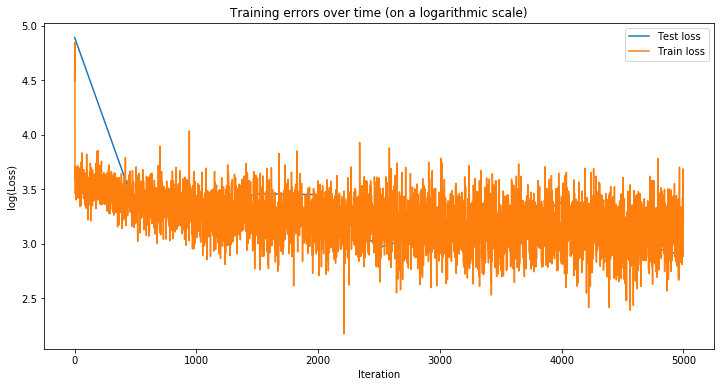

In [13]:
plt.figure(figsize=(12, 6))
plt.plot( 
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss" 
)
plt.plot( 
    np.log(train_losses), 
    label="Train loss" 
)
plt.title("Training errors over time (on a logarithmic scale)") 
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.legend(loc='best') 
plt.show()

Визуализация результата

Visualization:


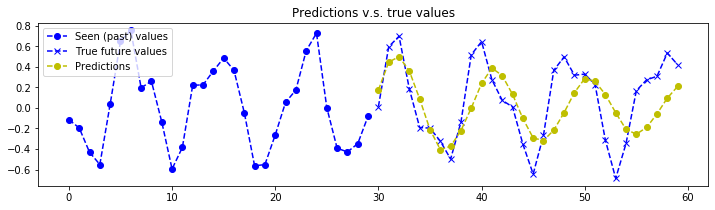

In [15]:
print("Visualization:")

X, Y = data_generation_v3(isTrain=False, batch_size = 1)
feed_dict = { enc_inp [t]: X[t] for t in range(seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

# выводим предсказания по каждому пакету
for j in range(1):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]

    label1 = "Seen (past) values" 
    label2 = "True future values"
    label3 = "Predictions"

    plt.plot(range(len(past)), past, "o--b", label = label1)
    plt.plot(range(len(past), len(expected) + len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past), len(pred) + len(past)), pred, "o--y", label = label3 )

    plt.legend(loc ='best')
    plt.title("Predictions v.s. true values")
    plt.show()